In [1]:
from attention import AttentionLayer
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
data = pd.read_csv("train_model_files/article_summary_and_article_title/sample_1000.csv")
data.drop_duplicates(subset=['article'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na rows

In [3]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [4]:
data=data.rename(columns = {'article': 'Text', 'title': 'Summary'})
data.head()

,Text,Summary
0,"russian foreign minister igor ivanov said tuesday that he and new secretary of state colin powell will hold their first meeting on feb. ## in cairo , egypt .",ivanov powell to meet this month
1,"french aerobatic team `` patrouille de france '' will stage an exciting performance in hong kong on oct. ## during its first visit to china , according to a press release issued by the consulate g...",french aerobatic team to stage performance in hk
2,spanish farmers hurled several thousand kilos -lrb- pounds -rrb- of tomatoes and eggs at the french embassy on saturday in reprisal for attacks on spanish produce in france .,spanish farmers hurl produce at french embassy
3,"european share retreated thursday , tracking declines on wall street , with technology stocks posting heavy losses after a bearish earnings outlook from nokia for the fourth quarter .",euro stocks slip on wall street losses nokia
4,a judge on wednesday said he will not impanel a new jury to decide whether to spare the life a man convicted in the bombing of a u.s. embassy in africa .,embassy bombings judge to keep jury


In [5]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [6]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [7]:
for i in range(2):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print()

Review: russian foreign minister igor ivanov said tuesday new secretary state colin powell hold first meeting feb cairo egypt
Summary: ivanov powell to meet this month 

Review: french aerobatic team patrouille france stage exciting performance hong kong oct first visit china according press release issued consulate general france hong kong wednesday
Summary: french aerobatic team to stage performance in hk 



In [8]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

<Figure size 640x480 with 2 Axes>

In [9]:
max_len_text=27
max_len_summary=15


In [10]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok') # start of sentence token, end of sentence token
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [11]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [12]:

#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [13]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [14]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(900, 900)

In [15]:
# latent_dim = 500 

# # Encoder 
# encoder_inputs = Input(shape=(max_len_text,)) 
# enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

# #LSTM 1 
# encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

# #LSTM 2 
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

# #LSTM 3 
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# # Set up the decoder. 
# decoder_inputs = Input(shape=(None,)) 
# dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
# dec_emb = dec_emb_layer(decoder_inputs) 

# #LSTM using encoder_states as initial state
# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
# decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

# #Attention Layer
# attn_layer = AttentionLayer(name='attention_layer') 
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# # Concat attention output and decoder LSTM output 
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# #Dense layer
# decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
# decoder_outputs = decoder_dense(decoder_concat_input) 

# # Define the model
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
# model.summary()

In [16]:
from keras import backend as K 
K.clear_session()


latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_len_text,))

#embedding layer
enc_emb =  Embedding(x_voc_size, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc_size, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 27, 100)      584200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 27, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [17]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [18]:
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],
                  y_tr.shape[1], 1)[:,1:],
                  epochs=10,
                  callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
                  batch_size=32,
                  validation_data=([x_val,y_val[:,:-1]],y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 900 samples, validate on 99 samples
Epoch 1/10
900/900 [==============================] - 30s 34ms/sample - loss: 5.1851 - val_loss: 3.6892
Epoch 2/10
900/900 [==============================] - 19s 22ms/sample - loss: 4.5070 - val_loss: 3.2904
Epoch 3/10
900/900 [==============================] - 19s 22ms/sample - loss: 4.2923 - val_loss: 3.1939
Epoch 4/10
900/900 [==============================] - 21s 24ms/sample - loss: 4.1747 - val_loss: 3.1407
Epoch 5/10
900/900 [==============================] - 23s 25ms/sample - loss: 4.0943 - val_loss: 3.1543
Epoch 00005: early stopping


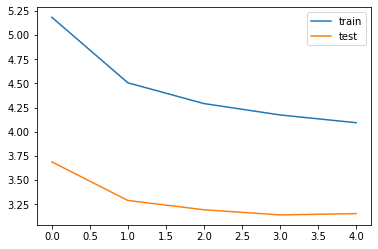

In [19]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

## Inferernce, decoder

In [20]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [21]:
# # encoder inference
# encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# # decoder inference
# # Below tensors will hold the states of the previous time step
# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# # Get the embeddings of the decoder sequence
# dec_emb2= dec_emb_layer(decoder_inputs)

# # To predict the next word in the sequence, set the initial states to the states from the previous time step
# decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# #attention inference
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# # A dense softmax layer to generate prob dist. over the target vocabulary
# decoder_outputs2 = decoder_dense(decoder_inf_concat)

# # Final decoder model
# decoder_model = Model(
# [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
# [decoder_outputs2] + [state_h2, state_c2])

In [22]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

# NEW TEST

In [23]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [26]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
#     print('e_out:', e_out)
#     print('e_h:', e_h)
#     print('e_c:', e_c)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']
    
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
#         print("output_tokens:", output_tokens)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         print(sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index]
        print(sampled_token)
        if(sampled_token!='eostok' and sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [27]:
for i in range(0,5):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: late gave win stoke saturday closed championship leaders sheffield united three points 
Original summary: keep up pressure 
china
says
to
to
to
to
to
to
eostok
Predicted summary:  china says to to to to to to


Review: china groups made great family planning ceremony held great hall people wednesday 
Original summary: for family planning 
china
says
to
to
to
to
to
to
eostok
Predicted summary:  china says to to to to to to


Review: spanish government tuesday allegations corruption socialist administration premier opening reports brother law received special treatment awarding public works contract 
Original summary: madrid new corruption allegations 
china
says
to
to
to
to
to
to
eostok
Predicted summary:  china says to to to to to to


Review: held colombian rebels said saturday efforts secure release would unless paris rebel revolutionary armed forces colombia lrb farc rrb positive return 
Original summary: says must be to release 
china
says
to
to
to
to
to
to
eostok
Predicted

In [28]:
x_val[i].reshape(1,max_len_text) # shows padding

array([[ 211,  490,   69,  383, 1969,  529, 2583, 2584,  220, 2000,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]])

In [ ]:
# def doubleData(x):
#     print(str(x))
#     if str(x).startswith('start'): 
#         print(str(x))
#         temp=str(x)
        
#         return True
# modDfObj = data.apply(doubleData)

In [29]:
for i in range(5):
    print(y_tr[i])

[  1 109   4  21  22 248  41   2   0   0   0   0   0   0   0]
[   1  143  382 1055 1056 1057    9  144  617 1058    2    0    0    0
    0]
[   1   10  383 1059   52 1060    2    0    0    0    0    0    0    0
    0]
[   1 1061 1062  110  190 1063  618    4 1064 1065    2    0    0    0
    0]
[   1   58   36  619 1066   15  191  620    2    0    0    0    0    0
    0]
